<a href="https://colab.research.google.com/github/EvenSol/NeqSim-Colab/blob/master/notebooks/reservoir/compositiongrad.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title Compositional gradient in a gas reservoir
#@markdown This notebook discuss compositional gradients in a gas reservoir
%%capture
!pip install git+https://github.com/Equinor/neqsim-python.git
import neqsim
from neqsim.thermo.thermoTools import *
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import math
%matplotlib inline

# Theory

http://www.ipt.ntnu.no/~curtis/courses/PhD-PVT/PVT-HOT-Vienna-May-2016x/e-course/Papers/Day2/SPE63085-Hoier-Whitson-Gradient-Theory-and-Practice.pdf

https://onepetro.org/SPEATCE/proceedings-abstract/15ATCE/15ATCE/D011S008R005/180533

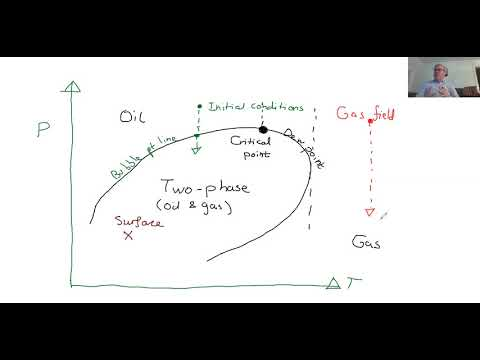

In [ ]:
#@title  Composition gradients in reservoirs
#@markdown Why compositional gradients?
from IPython.display import YouTubeVideo
YouTubeVideo('K05k9uGapFs', width=600, height=400)

# Calculation composition gradient in a reservoir

See model implementation:
https://github.com/equinor/neqsim/blob/1165af26e7e2271faf9cbfb0bfd05cb43c18310b/src/main/java/neqsim/thermodynamicoperations/flashops/TPgradientFlash.java

# Documentation for `TPgradientFlash.java`

The `TPgradientFlash` class performs thermodynamic calculations under temperature and pressure gradients, simulating fluid behavior in scenarios such as subsurface reservoirs or pipelines. The mathematical approach uses numerical methods to solve for changes in fluid composition and pressure along the gradient.

---

## 1. Class Overview

- **Purpose:** Handle thermodynamic equilibrium calculations under a defined temperature and pressure gradient.
- **Methods:**
  - `setfvec`: Constructs the vector of functions (`fvec`) representing thermodynamic equations.
  - `setJac`: Builds the Jacobian matrix, which is used to compute adjustments in composition and pressure.
  - `setNewX`: Updates fluid composition and pressure based on the computed adjustments.
  - `run`: Executes the gradient flash calculation iteratively.

---

## 2. Key Mathematics

### 2.1 Fugacity and Equilibrium Condition
- **Fugacity (f):** A thermodynamic property that represents the "effective pressure" of a component in a mixture.
- The equilibrium condition for each component \(i\) is:
  $$
  \ln(f_i) = \ln(f_i^*) - \Delta \Phi_i
  $$
  Where:
  - \(f_i = \text{fugacity coefficient} \times x_i \times P\) (local system)
  - \(f_i^* = \text{fugacity coefficient} \times x_i^* \times P^*\) (reference system)
  - \(\Delta \Phi_i = \frac{M_i \cdot g \cdot \Delta h}{R \cdot T}\): Accounts for gravitational potential energy, with:
    - \(M_i\): Molar mass of component \(i\)
    - \(g\): Gravitational acceleration
    - \(\Delta h\): Height difference
    - \(R\): Universal gas constant
    - \(T\): Temperature in Kelvin

### 2.2 Mass Balance Constraint
- The sum of mole fractions \(x_i\) must equal 1:
  $$
  \sum_{i=1}^{N} x_i = 1
  $$

### 2.3 Jacobian Matrix
- The Jacobian matrix \(J\) is the partial derivative of \(fvec\) with respect to \(x_i\) and \(P\). It provides the sensitivity of the system to changes in these variables:
  $$
  J_{ij} = \frac{\partial f_i}{\partial x_j}, \quad J_{iN} = \frac{\partial f_i}{\partial P}
  $$
  Where:
  - \(i, j\): Component indices
  - \(N\): Number of components

### 2.4 Iterative Solver
- Newton-Raphson method is used to solve for updates in mole fractions and pressure:
  $$
  J \cdot \Delta X = -fvec
  $$
  Where:
  - \(\Delta X\): Updates to mole fractions (\(x_i\)) and pressure (\(P\))
  - \(fvec\): Current residuals

---

## 3. Method Descriptions

### 3.1 `setfvec`
Constructs the residual vector \(fvec\) for each component:
1. **Logarithmic Difference:** Represents fugacity equilibrium between the local and reference systems.
2. **Gravitational Correction:** Adjusts for potential energy differences.
3. **Mass Balance Constraint:** Ensures mole fractions sum to 1.

**Mathematical Form:**
$$
f_i = \ln(f_i) - \ln(f_i^*) - \frac{M_i \cdot g \cdot \Delta h}{R \cdot T}
$$

---

### 3.2 `setJac`
Constructs the Jacobian matrix \(J\) with the following components:
1. **Diagonal Elements (\(J_{ii}\)):** Self-sensitivity of \(x_i\) or pressure.
2. **Off-Diagonal Elements (\(J_{ij}\)):** Cross-sensitivity between components.
3. **Mass Balance Row:** Ensures total mole fraction sums to 1.

---

### 3.3 `setNewX`
Applies updates (\(\Delta X\)) to mole fractions and pressure:
$$
x_i \leftarrow x_i - \lambda \cdot \Delta x_i
$$
$$
P \leftarrow P - \lambda \cdot \Delta P
$$
Where \(\lambda\) is a relaxation factor to ensure numerical stability.

---

### 3.4 `run`
Executes the flash calculation iteratively:
1. **Initialize the system:** Set gradients for height (\(\Delta h\)) and temperature (\(\Delta T\)).
2. **Iterative Solution:**
   - Compute \(fvec\) (residuals).
   - Build the Jacobian matrix \(J\).
   - Solve for updates (\(\Delta X\)) using matrix operations.
   - Apply updates and normalize.
3. **Convergence Criteria:** The solution converges when \(\|\Delta X\|_2\) (L2 norm) is below a tolerance value.

---

## 4. Numerical Workflow

1. **Initialization:**
   - Clone the thermodynamic system to maintain a local and reference system.
   - Set gradient parameters (\(\Delta T, \Delta h\)).

2. **Iterative Solution:**
   - Compute \(fvec\) (residuals).
   - Build the Jacobian matrix \(J\).
   - Solve for updates (\(\Delta X\)).
   - Apply updates and normalize.

3. **Convergence Criteria:**
   - The solution converges when \(\|\Delta X\|_2\) (L2 norm) is below a tolerance value.

---

## 5. Applications

- Simulates fluid behavior in reservoirs with significant depth differences.
- Evaluates fluid composition changes in pipelines with temperature and pressure gradients.
- Ensures accurate modeling of phase equilibria under varying environmental conditions.


# Calculation of composition gradient with NeqSim

In [ ]:
# Creating a fluid in neqsim

pressure = 150.0
temperature = 100.0
fluid1 = fluid('srk') #create a fluid using the SRK-EoS
fluid1.addComponent('methane', 0.99)
fluid1.addComponent('n-heptane', 0.01)
fluid1.setTemperature(temperature, "C")
fluid1.setPressure(pressure, "bara")
dewpointtemperature = dewt(fluid1)
printFrame(fluid1)

newFluid = TPgradientFlash(fluid1, height = 1000.0, temperature=dewpointtemperature+1.0).phaseToSystem(0)

printFrame(newFluid)

| 0                    | 1          | 2                 | 3                 | 4   | 5   | 6               |
|:---------------------|:-----------|:------------------|:------------------|:----|:----|:----------------|
|                      | total      | GAS               | OIL               |     |     |                 |
| methane              | 9.9E-1     | 9.9E-1            | 9.9E-1            |     |     | [mole fraction] |
| n-heptane            | 1E-2       | 1E-2              | 1.00001E-2        |     |     | [mole fraction] |
|                      |            |                   |                   |     |     |                 |
| Density              |            | 8.68499E1         | 8.685E1           |     |     | kg/m3           |
| Phase Fraction       |            | 1E0               | 1E-15             |     |     | [mole fraction] |
| Molar Mass           | 1.68846E-2 | 1.68846E-2        | 1.68846E-2        |     |     | kg/mol          |
| Z factor             |    

# Example of composition gradient in a gas reservoir with hydrogen

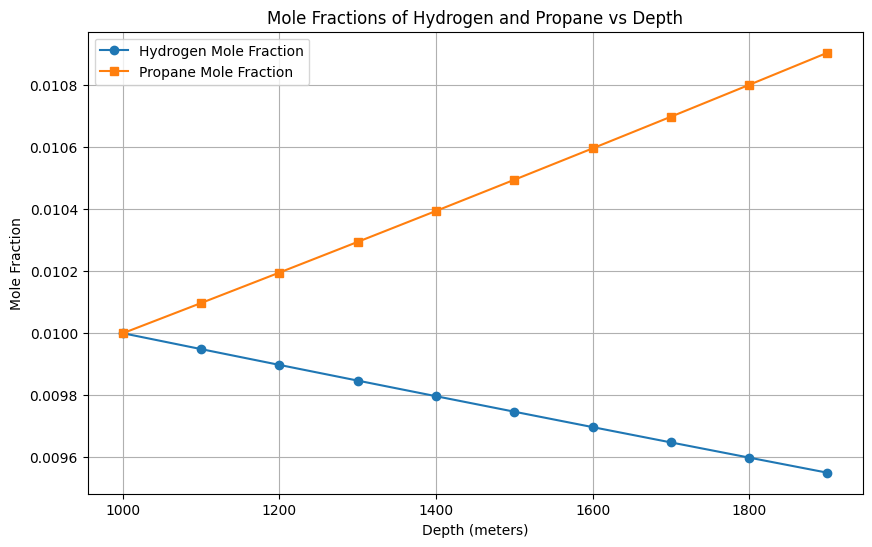

In [ ]:
temperature = 70.0 #C
init_pressure = 100.0 #sample pressure
ref_depth = 1000.0

fluid1 = fluid("pr")  # create a fluid using the SRK-EoS
fluid1.setTemperature(temperature, "C")
fluid1.setPressure(init_pressure, "bara")
fluid1.addComponent("hydrogen", 1.0, "mol/sec")
fluid1.addComponent("CO2", 1.0, "mol/sec")
fluid1.addComponent("methane", 96.0, "mol/sec")
fluid1.addComponent("ethane", 1.0, "mol/sec")
fluid1.addComponent("propane", 1.0, "mol/sec")
fluid1.setMixingRule("classic")  # classic will use binary kij
# True if more than two phases could be present
TPflash(fluid1)

pressure = []
depth = []
x_hydrogen = []
x_propane = []

delta_depth = 100.0 #meter
delta_temperature = 0.5 #C per 100 meter

for i in range(10):
  depth.append(ref_depth+i*delta_depth)
  deep_fluid = TPgradientFlash(fluid1, i*delta_depth, 273.15+temperature+i*delta_temperature)
  pressure.append(deep_fluid.getPressure('bara'))
  x_hydrogen.append(deep_fluid.getComponent('hydrogen').getx())
  x_propane.append(deep_fluid.getComponent('propane').getx())


# Plotting mole fractions vs. depth
plt.figure(figsize=(10, 6))
plt.plot(depth, x_hydrogen, label="Hydrogen Mole Fraction", marker='o')
plt.plot(depth, x_propane, label="Propane Mole Fraction", marker='s')
plt.xlabel("Depth (meters)")
plt.ylabel("Mole Fraction")
plt.title("Mole Fractions of Hydrogen and Propane vs Depth")
plt.legend()
plt.grid(True)
plt.show()